# Summary


Depends on `elaspic_training_interface`.

----

# Imports

In [94]:
%run imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-09-23 17:38:41.769062


In [95]:
%run db.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MySQL database already running...


2016-09-23 17:38:41.920287


In [96]:
NOTEBOOK_NAME = 'machine_learning'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

# Parameters

In [97]:
CORE_OR_INTERFACE = 1

# Load data

In [98]:
# Set CORE parameters
if CORE_OR_INTERFACE in [0, 'core']:
    COI_SUFFIX = '_CORE'
    TRAINING_DATASET_NAME = 'protherm++'
    DATA_DF = pd.read_pickle(op.join('load_data', 'DATA_DF_TT_CORE.pkl'))

    # Make sure we are not including any interface mutations in our training set
    assert (DATA_DF['mutation_in_interface'] == 0).all()

    EXCLUDED_COLUMNS = ['dg_wt', 'dg_mut', 'dg_change']
    FEATURE_COLUMNS = [
        f for f in elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE if f not in EXCLUDED_COLUMNS
    ]
    DATASETS = [
        # Train
        TRAINING_DATASET_NAME,
        # Validate
        'taipale_train',
        'humsavar_train',
        'clinvar_train',
        'cosmic_train',
        # Test datasets (not used for cross-validation / feature elimination)
        'humsavar_test',
        'clinvar_test',
        'cosmic_test',
        # External datasets
        'cagi4_sumo_ligase',
        'ab_bind',
        'hiv_escape_mutations',
        'benedix_et_al',
    ]

In [99]:
# Set INTERFACE parameters
if CORE_OR_INTERFACE in [1, 'interface']:
    COI_SUFFIX = '_INTERFACE'
    TRAINING_DATASET_NAME = 'skempi++'
    DATA_DF = pd.read_pickle(op.join('load_data', 'DATA_DF_TT_INTERFACE.pkl'))
    EXCLUDED_COLUMNS = ['dg_wt', 'dg_mut', 'dg_change']
    FEATURE_COLUMNS = [
        f for f in elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE if f not in EXCLUDED_COLUMNS
    ]
    DATASETS = [
        TRAINING_DATASET_NAME,
        'taipale_train',
        'taipale_ppi_train',
        'taipale_gpca_train',
        'humsavar_train',
        'clinvar_train',
        'cosmic_train',
        # Test datasets (not used for cross-validation / feature elimination)
        'humsavar_test',
        'clinvar_test',
        'cosmic_test',
        #
        'cagi4_sumo_ligase',
        'ab_bind',
        'hiv_escape_mutations',
        'benedix_et_al',
    ]

In [100]:
DATA_DF.loc[DATA_DF['dataset'] == 'taipale', 'dataset'] = 'taipale_train'
DATA_DF.loc[DATA_DF['dataset'] == 'taipale_ppi', 'dataset'] = 'taipale_ppi_train'
DATA_DF.loc[DATA_DF['dataset'] == 'taipale_gpca', 'dataset'] = 'taipale_gpca_train'    

In [101]:
_before = DATA_DF.shape[0]
DATA_DF = DATA_DF[
    DATA_DF['uniprot_mutation'].isnull() |
    ~DATA_DF['uniprot_mutation'].str.contains('\.').astype(bool)
]
DATA_DF_SHAPE = DATA_DF.shape
print("Lost {} multi-mutation rows.".format(_before - DATA_DF_SHAPE[0]))

Lost 12 multi-mutation rows.


In [102]:
DATA_DF['uniprot_mutation'].isnull().sum()

318

In [103]:
DATA_DF.shape

(83444, 165)

## Add pfam clan info

**We should do this at the Gene3d level in the future!!!**
  - Could maybe even have different priors for different domains?...

### pfam_a_clans

In [104]:
sql_query = """\
SELECT *
from pfam.pfam_a_clans
"""
pfam_a_clans = pd.read_sql_query(sql_query, db_remote.engine)

In [105]:
pfam_a_clans[pfam_a_clans['pfam_id'] == 'PF08917']

,pfam_id,clan_id,clan_name,pfam_name,pfam_description
8278,PF08917,None,None,ecTbetaR2,Transforming growth factor beta receptor 2 ect...


### pfam_a_regions

In [106]:
sql_query = """\
SELECT *
from pfam.pfam_a_regions
where uniprot_id in ({})
""".format(", ".join(DATA_DF['uniprot_id'].drop_duplicates().apply(lambda x: "'{}'".format(x))))

pfam_a_regions = pd.read_sql_query(sql_query, db_remote.engine)

In [107]:
pfam_a_regions.head()

,uniprot_id,uniprot_version,md5_hash,sha_hash,pfam_id,domain_start,domain_end
0,A0AV96,2,AEA061F89A68010B,43e5d2c9e7b66af6a591447dcdae08dc,PF00076,73,141
1,A0AV96,2,AEA061F89A68010B,43e5d2c9e7b66af6a591447dcdae08dc,PF00076,248,312
2,A0AV96,2,AEA061F89A68010B,43e5d2c9e7b66af6a591447dcdae08dc,PF00076,153,220
3,A0AVT1,1,9F9C70EABA750A71,65027d916a0db3ff5429abd81efac9bc,PF00899,459,603
4,A0AVT1,1,9F9C70EABA750A71,65027d916a0db3ff5429abd81efac9bc,PF00899,60,198


### data_with_pfam

In [108]:
data_with_pfam = (
    DATA_DF[['uniprot_id', 'uniprot_mutation']]
    .merge(
        pfam_a_regions[['uniprot_id', 'pfam_id', 'domain_start', 'domain_end']],
        on=['uniprot_id'],
    )
    .merge(
        pfam_a_clans[['pfam_id', 'clan_id']],
        on=['pfam_id'],
        how='left',
    )
)

In [109]:
data_with_pfam['uniprot_mutation_pos'] = data_with_pfam['uniprot_mutation'].str[1:-1].astype(float)

In [110]:
data_with_pfam = (
    data_with_pfam[
        (data_with_pfam['domain_start'] <= data_with_pfam['uniprot_mutation_pos']) &
        (data_with_pfam['uniprot_mutation_pos'] <= data_with_pfam['domain_end'])
    ]
)

In [111]:
data_with_pfam.head()

,uniprot_id,uniprot_mutation,pfam_id,domain_start,domain_end,clan_id,uniprot_mutation_pos
4,Q9Y5Y6,Q783A,PF00089,615,849,CL0124,783.0
12,Q9Y5Y6,H752A,PF00089,615,849,CL0124,752.0
20,Q9Y5Y6,Q754A,PF00089,615,849,CL0124,754.0
28,Q9Y5Y6,K835A,PF00089,615,849,CL0124,835.0
36,Q9Y5Y6,N704A,PF00089,615,849,CL0124,704.0


In [112]:
data_with_pfam['lco_id'] = data_with_pfam['clan_id']
data_with_pfam.loc[data_with_pfam['lco_id'].isnull(), 'lco_id'] = (
    data_with_pfam.loc[data_with_pfam['lco_id'].isnull(), 'pfam_id']
)

In [113]:
data_with_pfam['unique_id'] = data_with_pfam['uniprot_id'] + '.' + data_with_pfam['uniprot_mutation']

In [114]:
unique_id_to_lco_id = {
    x[0]: x[1] for x in data_with_pfam[['unique_id', 'lco_id']].sort_values('lco_id').values
}

### lco_id

In [115]:
DATA_DF['unique_id'] = DATA_DF['uniprot_id'] + '.' + DATA_DF['uniprot_mutation']

In [116]:
DATA_DF['lco_id'] = np.nan
DATA_DF['lco_id'].isnull().sum()

83444

In [117]:
pfam_id_to_clan_id = {
    x[0]: x[1] for x in pfam_a_clans[['pfam_id', 'clan_id']].dropna().sort_values('clan_id').values
}

In [118]:
DATA_DF['lco_id'] = DATA_DF['pfam_id'].map(pfam_id_to_clan_id)
DATA_DF['lco_id'].isnull().sum()

80870

In [119]:
DATA_DF.loc[DATA_DF['lco_id'].isnull() & DATA_DF['pfam_id'].notnull(), 'lco_id'] = (
    DATA_DF.loc[DATA_DF['lco_id'].isnull() & DATA_DF['pfam_id'].notnull(), 'pfam_id']
)
DATA_DF['lco_id'].isnull().sum()

80690

In [120]:
DATA_DF.loc[DATA_DF['lco_id'].isnull(), 'lco_id'] = (
    DATA_DF.loc[DATA_DF['lco_id'].isnull(), 'unique_id'].map(unique_id_to_lco_id)
)
DATA_DF['lco_id'].isnull().sum()

12379

In [121]:
uniprot_to_lco_id = {
    x[0]: x[1] for x in DATA_DF[['uniprot_id', 'lco_id']].dropna().sort_values('lco_id').values
}

In [122]:
DATA_DF.loc[DATA_DF['lco_id'].isnull(), 'lco_id'] = (
    DATA_DF.loc[DATA_DF['lco_id'].isnull(), 'uniprot_id'].map(uniprot_to_lco_id)
)
DATA_DF['lco_id'].isnull().sum()

1092

In [123]:
DATA_DF.loc[DATA_DF['lco_id'].isnull(), 'lco_id'] = 'xxx'
DATA_DF['lco_id'].isnull().sum()

0

In [124]:
assert DATA_DF['lco_id'].notnull().all()

### lco_group

In [125]:
def get_class_sets(*, n_classes=6, **args):
    """
    args : Counter
        key : num rows assigned to that key
    """
    args = sorted(args.items(), key=lambda x: x[1], reverse=True)
    num_rows = sum(v[1] for v in args)
    rows_per_class = num_rows // n_classes + 1

    class_sets = []
    for i in range(n_classes):
        class_set = {args.pop(0)}
        while sum(v[1] for v in class_set) < rows_per_class:
            try:
                class_set.add(args.pop(-1))
            except IndexError:
                break
        class_sets.append(class_set)
    assert not args
    return class_sets

In [126]:
c = {
    str(k): v for k, v 
    in Counter(DATA_DF[DATA_DF['dataset'] == TRAINING_DATASET_NAME]['lco_id']).items()
}
class_sets = get_class_sets(n_classes=4, **c)
print([sum(x[1] for x in d) for d in class_sets])

[1121, 886, 862, 524]


In [127]:
DATA_DF['lco_group'] = None

for i, class_set in enumerate(class_sets):
    cs = {k[0] for k in class_set}
    print('{:d}:\t{}'.format(i, cs))
    DATA_DF.loc[
        ((DATA_DF['dataset'] == TRAINING_DATASET_NAME) &
         (DATA_DF['lco_id'].isin(cs))),
        'lco_group'] = i

assert DATA_DF[DATA_DF['dataset'] == TRAINING_DATASET_NAME]['lco_group'].notnull().all()

0:	{'CL0005'}
1:	{'CL0096', 'PF08816', 'CL0159', 'CL0013', 'PF00720', 'PF08917', 'PF12199', 'PF00141', 'CL0117', 'PF01337', 'PF02312', 'PF09408', 'CL0326', 'CL0010', 'PF05375', 'PF07924', 'CL0431', 'CL0124', 'CL0304', 'CL0318', 'PF09078', 'CL0214', 'CL0072', 'CL0079', 'PF00228', 'CL0084', 'PF01123', 'CL0023', 'CL0208', 'PF02216', 'CL0202', 'PF01378', 'PF00545', 'CL0148', 'CL0108', 'PF03974', 'CL0386', 'CL0028'}
2:	{'CL0053', 'CL0353', 'xxx', 'CL0367', 'CL0263', 'CL0022', 'CL0320', 'CL0037', 'PF00074'}
3:	{'PF01320', 'CL0454', 'CL0011'}


In [128]:
assert DATA_DF.shape[0] == DATA_DF_SHAPE[0]

## TRAINING_SETS_NONULL

In [36]:
# Remove rows with missing features
TRAINING_SETS_NONULL = OrderedDict()
for dataset in DATASETS:
    print(dataset)
    df = DATA_DF[DATA_DF['dataset'] == dataset]
    # df = elaspic.elaspic_predictor.format_mutation_features(df)
    # Keep mut, remove it in next step
    # df = elaspic.elaspic_predictor.convert_features_to_differences(df, True)
    _shape_before = df.shape[0]
    for f in FEATURE_COLUMNS + ['ddg_exp']:
        num_null = df[f].isnull().sum()
        if num_null:
            print2("Null column: '{}'".format(f), num_null)
    df = df.dropna(subset=FEATURE_COLUMNS, how='any')
    df = df.dropna(subset=['ddg_exp', 'del_score_exp', 'del_class_exp'], how='all')
    _shape_after = df.shape[0]
    TRAINING_SETS_NONULL[dataset] = df

    print2("Shape before:", "{:,d}".format(_shape_before), x=20)
    print2("Shape after:", "{:,d}".format(_shape_after), x=20)
    print2("Rows lost:", "{:,d}".format(_shape_before - _shape_after), x=20)
    print('-' * 40)

skempi++
Shape before:       3,393
Shape after:        3,393
Rows lost:          0
----------------------------------------
taipale_train
Null column: 'provean_score'                                1
Shape before:       554
Shape after:        553
Rows lost:          1
----------------------------------------
taipale_ppi_train
Shape before:       267
Shape after:        267
Rows lost:          0
----------------------------------------
taipale_gpca_train
Shape before:       179
Shape after:        179
Rows lost:          0
----------------------------------------
humsavar_train
Null column: 'provean_score'                                172
Null column: 'norm_dope'                                    1
Null column: 'ddg_exp'                                      5565
Shape before:       5,565
Shape after:        5,392
Rows lost:          173
----------------------------------------
clinvar_train
Null column: 'provean_score'                                72
Null column: 'norm_dope'      

In [37]:
_training_set_notnull_rows = sum(df.shape[0] for df in TRAINING_SETS_NONULL.values())
assert _training_set_notnull_rows <= DATA_DF_SHAPE[0]
print("Lost {} rows in our not-null training set.".format(DATA_DF_SHAPE[0] - _training_set_notnull_rows))

Lost 685 rows in our not-null training set.


In [38]:
with open(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX)), 'wb') as ofh:
    pickle.dump(TRAINING_SETS_NONULL, ofh)

# Cross-validation

In [39]:
with open(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX)), 'rb') as ifh:
    TRAINING_SETS_NONULL = pickle.load(ifh)

## system_commands

In [40]:
SCRIPT_NAME = 'gridsearch.py'

In [41]:
# Generate a list of parameters that we want to try...
parameter_grid =  {
    'data_set': [TRAINING_DATASET_NAME],
    'data_file': [op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX)))],
    'n_estimators': [2000],
    'loss': ['huber'],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6,   8, 10],
    'min_samples_leaf': [3, 5, 9, 13, 17,   21, 29],
    'max_features': [1.0, 0.3, 0.1,   0.8, 0.5],
    'alpha': [0.99, 0.95, 0.9, 0.8, 0.7, 0.5],
    'features': [':'.join([f for f in FEATURE_COLUMNS if f not in ['dg_change']])],
}


def get_system_command(**params):
    system_command = (
        "{python} {script} {args}".format(
            python=sys.executable,
            script=op.abspath(op.join(NOTEBOOK_NAME, SCRIPT_NAME)),
            args=' '.join(sorted("--{} {}".format(*x) for x in params.items())))
    )
    return system_command


system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**parameter_grid))
]

print("Size of the parameter grid: ", len(system_commands))

Size of the parameter grid:  3360


In [42]:
system_commands[0]

(0,
 '/home/kimlab1/strokach/anaconda/bin/python /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/machine_learning/gridsearch.py --alpha 0.99 --data_file /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/machine_learning/TRAINING_SETS_NONULL_INTERFACE.pkl --data_set skempi++ --features intraclashes_energy_1_wt:intraclashes_energy_2_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:intraclashes_energy_1_change:intraclashes_energy_2_change:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:v

## gridsearch.py

In [43]:
%%file $NOTEBOOK_NAME/$SCRIPT_NAME
import os
import os.path as op
import pickle
import json
import scipy as sp
import pandas as pd
import sqlalchemy as sa
from sklearn import ensemble, cross_validation, metrics
import elaspic


def cross_validate(train_df, valid_dfs, opts, features, do_xval, target='ddg_exp', label='lco_group'):
    # Initialize classifier
    clf = ensemble.GradientBoostingRegressor(**opts)
    
    # Keep track of results
    result = {}
    def add_stats(actual, predicted, suffix=''):
        result.update({
                'r2{}'.format(suffix): metrics.r2_score(actual, predicted),
                'pearsonr{}'.format(suffix): sp.stats.pearsonr(actual, predicted)[0],
                'spearmanr{}'.format(suffix): sp.stats.spearmanr(actual, predicted)[0],
            })

    # Cross-validation        
    if do_xval:
        preds = cross_validation.cross_val_predict(
            estimator=clf,
            X=train_df[features],
            y=train_df[target],
            cv=cross_validation.LeaveOneLabelOut(train_df[label].fillna('')),
            n_jobs=1,
        )
        add_stats(train_df[target], preds)

    # Fit the classifier
    clf.fit(train_df[features], train_df[target])

    # Validation on our 'test' sets
    for valid_name, valid_df in valid_dfs.items():
        valid_df['pred'] = clf.predict(valid_df[features])
        for col_name, do_abs in [
                ('ddg_exp', False),
                ('del_score_exp', False),
                ('del_score_exp', True),
                ('del_class_exp', False),
                ('del_class_exp', True)]:
            if not valid_df[col_name].notnull().all():
                continue
            actual = valid_df[col_name].abs() if do_abs else valid_df[col_name]
            predicted = valid_df['pred'].abs() if do_abs else valid_df['pred']
            suffix = '_{}_{}_vs_ddg{}'.format(valid_name, col_name, '_abs' if do_abs else '')
            add_stats(actual, predicted, suffix)
            for cutoff_name, cutoff_func in [
                    # This bit is different by 100x compared to CORE
                    ('gt80', lambda x: x > 0.80),
                    ('40to80', lambda x: (x <= 0.80) & (x > 0.40)),
                    ('lt40', lambda x: x <= 0.40)]:
                keep_idx = valid_df['alignment_identity'].apply(cutoff_func)
                if (~keep_idx).all():
                    print("No samples found for '{}'".format(suffix + '_' + cutoff_name))
                    continue
                add_stats(actual[keep_idx], predicted[keep_idx], suffix + '_' + cutoff_name)

    # DONE!
    return result


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_set', type=str, required=True)
    parser.add_argument('--data_file', type=str, required=True)
    parser.add_argument('--features', type=str, default=None)
    parser.add_argument('--do_xval', type=int, default=1)
    #
    parser.add_argument('--learning_rate', type=float, required=True)
    parser.add_argument('--max_depth', type=int, required=True)
    parser.add_argument('--min_samples_leaf', type=int, required=True)
    parser.add_argument('--max_features', type=float, required=True)
    parser.add_argument('--alpha', type=float, required=True)
    #
    parser.add_argument('--loss', type=str, default='huber')
    parser.add_argument('--n_estimators', type=int, default=3000)
    #
    args = parser.parse_args()

    with open(args.data_file, 'rb') as ifh:
        TRAINING_SETS = pickle.load(ifh)
    
    train_df = TRAINING_SETS[args.data_set]
    validation_dfs = {
        # Training / validation datasets
        **{
            key.replace('_train', ''): df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_train')
        },
        # Test datasets
        **{
            key: df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_test')
        },
    }
    clf_opts = {
        k: v for (k, v) in args.__dict__.items()
        if k not in ['data_set', 'data_file', 'features', 'do_xval']
    }
    features = args.features.split(':')
        
    clf_result = cross_validate(train_df, validation_dfs, clf_opts, features, do_xval=bool(args.do_xval))

    result = {'clf_opts': clf_opts, 'features': args.features, **clf_result}
    print(json.dumps(result))

Overwriting machine_learning/gridsearch.py


In [44]:
!echo {system_commands[0][1]}

/home/kimlab1/strokach/anaconda/bin/python /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/machine_learning/gridsearch.py --alpha 0.99 --data_file /home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/machine_learning/TRAINING_SETS_NONULL_INTERFACE.pkl --data_set skempi++ --features intraclashes_energy_1_wt:intraclashes_energy_2_wt:backbone_hbond_wt:sidechain_hbond_wt:van_der_waals_wt:electrostatics_wt:solvation_polar_wt:solvation_hydrophobic_wt:van_der_waals_clashes_wt:entropy_sidechain_wt:entropy_mainchain_wt:sloop_entropy_wt:mloop_entropy_wt:cis_bond_wt:torsional_clash_wt:backbone_clash_wt:helix_dipole_wt:water_bridge_wt:disulfide_wt:electrostatic_kon_wt:partial_covalent_bonds_wt:energy_ionisation_wt:entropy_complex_wt:number_of_residues:intraclashes_energy_1_change:intraclashes_energy_2_change:backbone_hbond_change:sidechain_hbond_change:van_der_waals_change:electrostatics_change:solvation_polar_change:solvation_hydrophobic_change:van_der

## QSUB

In [45]:
SUFFIX = '_10'
JOB_NAME = '{}{}{}'.format(SCRIPT_NAME.replace('.py', ''), COI_SUFFIX.lower(), SUFFIX)
PATH = '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'

In [46]:
print(JOB_NAME)

gridsearch_interface_10


In [47]:
js = jobsubmitter.JobSubmitter(
    JOB_NAME, 'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
)

Using an existing folder for log output. This is dangerous!!!


In [48]:
js.job_name

'gridsearch_interface_10'

## Resubmit failed

In [49]:
# Get job status
gridsearch_results_1 = js.job_status(system_commands)
print(Counter(gridsearch_results_1['status']))

Counter({'done': 3360})


In [50]:
# Job statistics
failed = set(gridsearch_results_1[gridsearch_results_1['status'] != 'done']['job_id'])
system_commands_remaining = [x for x in system_commands if x[0] in failed]
system_commands_remaining = list(reversed(system_commands_remaining))
print(len(system_commands_remaining))

0


In [51]:
assert not system_commands_remaining

## Results

In [52]:
CORRELATION_TYPE = 'spearmanr'

In [53]:
# Compute FoldX correlations at different sequence identity cutoffs
foldx_corrs = {}

for cutoff_name, cutoff_func in [
        ('', lambda x: True),
        ('_gt80', lambda x: x > 0.80),
        ('_40to80', lambda x: (x <= 0.80) & (x > 0.40)),
        ('_lt40', lambda x: x <= 0.40)]:
    print("Cutoff name: {}".format(cutoff_name))
    foldx_corrs.update({
        '{}{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL[TRAINING_DATASET_NAME][
                TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['alignment_identity'].apply(cutoff_func)
            ]['dg_change'].values,
            TRAINING_SETS_NONULL[TRAINING_DATASET_NAME][
                TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['alignment_identity'].apply(cutoff_func)
            ]['ddg_exp'].values
        )[0],
        '{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['humsavar_train'][
                TRAINING_SETS_NONULL['humsavar_train']['alignment_identity'].apply(cutoff_func)
            ]['dg_change'].values,
            TRAINING_SETS_NONULL['humsavar_train'][
                TRAINING_SETS_NONULL['humsavar_train']['alignment_identity'].apply(cutoff_func)
            ]['del_class_exp'].values
        )[0],
        '{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['clinvar_train'][
                TRAINING_SETS_NONULL['clinvar_train']['alignment_identity'].apply(cutoff_func)
            ]['dg_change'].values,
            TRAINING_SETS_NONULL['clinvar_train'][
                TRAINING_SETS_NONULL['clinvar_train']['alignment_identity'].apply(cutoff_func)
            ]['del_class_exp'].values
        )[0],
        '{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['cosmic_train'][
                TRAINING_SETS_NONULL['cosmic_train']['alignment_identity'].apply(cutoff_func)
            ]['dg_change'].values,
            TRAINING_SETS_NONULL['cosmic_train'][
                TRAINING_SETS_NONULL['cosmic_train']['alignment_identity'].apply(cutoff_func)
            ]['del_class_exp'].values
        )[0],
        '{}_taipale_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['taipale_train'][
                TRAINING_SETS_NONULL['taipale_train']['alignment_identity'].apply(cutoff_func)
            ]['dg_change'].values,
            TRAINING_SETS_NONULL['taipale_train'][
                TRAINING_SETS_NONULL['taipale_train']['alignment_identity'].apply(cutoff_func)
            ]['del_class_exp'].values
        )[0],
    })
    
    
    if CORE_OR_INTERFACE in [1, 'interface']:
        foldx_corrs.update({
            '{}_taipale_ppi_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
                TRAINING_SETS_NONULL['taipale_ppi_train'][
                    TRAINING_SETS_NONULL['taipale_ppi_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].values,
                TRAINING_SETS_NONULL['taipale_ppi_train'][
                    TRAINING_SETS_NONULL['taipale_ppi_train']['alignment_identity'].apply(cutoff_func)
                ]['ddg_exp'].values
            )[0],
            '{}_taipale_gpca_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
                TRAINING_SETS_NONULL['taipale_gpca_train'][
                    TRAINING_SETS_NONULL['taipale_gpca_train']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].values,
                TRAINING_SETS_NONULL['taipale_gpca_train'][
                    TRAINING_SETS_NONULL['taipale_gpca_train']['alignment_identity'].apply(cutoff_func)
                ]['ddg_exp'].values
            )[0]
        })

Cutoff name: 
Cutoff name: _gt80
Cutoff name: _40to80
Cutoff name: _lt40


In [54]:
sorted(foldx_corrs.keys())

['spearmanr',
 'spearmanr_40to80',
 'spearmanr_clinvar_del_class_exp_vs_ddg',
 'spearmanr_clinvar_del_class_exp_vs_ddg_40to80',
 'spearmanr_clinvar_del_class_exp_vs_ddg_gt80',
 'spearmanr_clinvar_del_class_exp_vs_ddg_lt40',
 'spearmanr_cosmic_del_class_exp_vs_ddg',
 'spearmanr_cosmic_del_class_exp_vs_ddg_40to80',
 'spearmanr_cosmic_del_class_exp_vs_ddg_gt80',
 'spearmanr_cosmic_del_class_exp_vs_ddg_lt40',
 'spearmanr_gt80',
 'spearmanr_humsavar_del_class_exp_vs_ddg',
 'spearmanr_humsavar_del_class_exp_vs_ddg_40to80',
 'spearmanr_humsavar_del_class_exp_vs_ddg_gt80',
 'spearmanr_humsavar_del_class_exp_vs_ddg_lt40',
 'spearmanr_lt40',
 'spearmanr_taipale_ddg_exp_vs_ddg',
 'spearmanr_taipale_ddg_exp_vs_ddg_40to80',
 'spearmanr_taipale_ddg_exp_vs_ddg_gt80',
 'spearmanr_taipale_ddg_exp_vs_ddg_lt40',
 'spearmanr_taipale_gpca_ddg_exp_vs_ddg',
 'spearmanr_taipale_gpca_ddg_exp_vs_ddg_40to80',
 'spearmanr_taipale_gpca_ddg_exp_vs_ddg_gt80',
 'spearmanr_taipale_gpca_ddg_exp_vs_ddg_lt40',
 'spearman

In [55]:
# Column names
ABS = ''

columns = [
    CORRELATION_TYPE,
    '{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS),
    '{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS),
    '{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS),
    # 
]

if CORE_OR_INTERFACE in [0, 'core']:
    columns += [
        '{}_taipale_ddg_exp_vs_ddg'.format(CORRELATION_TYPE),
    ]


if CORE_OR_INTERFACE in [1, 'interface']:
    columns += [
        '{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE),
        '{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE),
    ]

columns.append('correlation_avg')

column_names = {
    CORRELATION_TYPE: 'Cross-validation',
    'correlation_avg': 'Training combined',
    '{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): 'Humsavar',
    '{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): 'ClinVar',
    '{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS): 'COSMIC',
    '{}_taipale_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): 'Taipale',
    '{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): 'Taipale PPI',
    '{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE): 'Taipale GPCA',
}


def get_correlation_avg(df):
    if CORE_OR_INTERFACE in [0, 'core']:
        return (
            df[CORRELATION_TYPE] * 3 + 
            df['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
            df['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
            df['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] +
            df['{}_taipale_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)]
        ) / 7.0
    if CORE_OR_INTERFACE in [1, 'interface']:
        return (
            df[CORRELATION_TYPE] * 3 + 
            df['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
            df['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] + 
            df['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)] +
            # df['{}_taipale_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 3 +
            df['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4 +
            df['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)] / 4
        ) / 6.5

In [56]:
# Prepare results for plotting (get `df`)
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1.5)

_before = gridsearch_results_1.shape[0]
DF = gridsearch_results_1.dropna(subset=[c for c in columns if c != 'correlation_avg']).copy()
_after = DF.shape[0]
print("Lost {} rows.".format(_before - _after))

print(gridsearch_results_1.shape)

DF['correlation_avg'] = get_correlation_avg(DF)

DF = DF.sort_values('correlation_avg', ascending=True)
DF.index = range(DF.shape[0])

print(DF.shape)
display(DF[columns].iloc[-1])

Lost 0 rows.
(3360, 260)
(3360, 261)


spearmanr                                  0.399484
spearmanr_humsavar_del_class_exp_vs_ddg    0.262813
spearmanr_clinvar_del_class_exp_vs_ddg     0.172113
spearmanr_cosmic_del_class_exp_vs_ddg      0.126179
spearmanr_taipale_ppi_ddg_exp_vs_ddg       0.295734
spearmanr_taipale_gpca_ddg_exp_vs_ddg      0.334903
correlation_avg                            0.294956
Name: 3359, dtype: float64

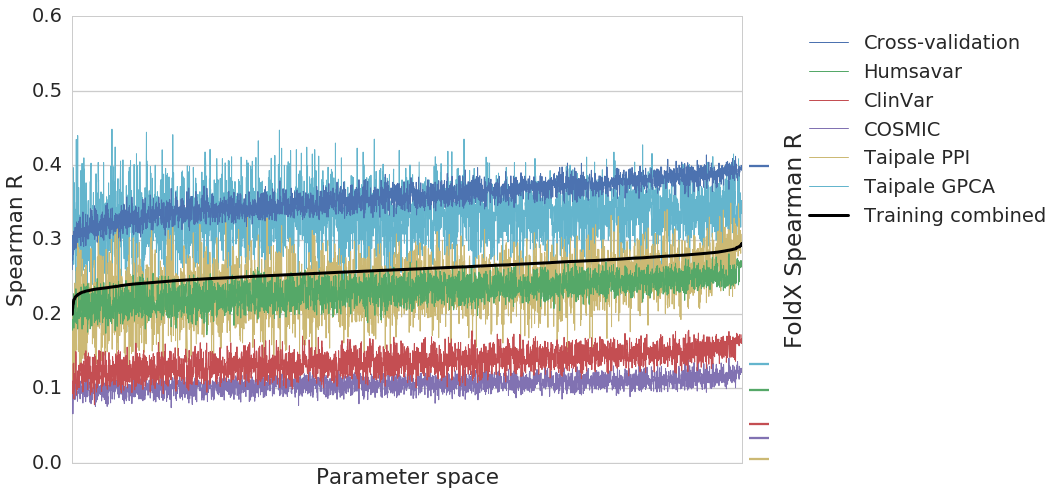

In [57]:
# Plot gridsearch over parameter space
fg, ax = plt.subplots(figsize=(12, 8))

ax = (
    DF[columns]
    .rename(columns=column_names)
    .plot(xticks=[], ax=ax, linewidth=1, color=sns.palettes.color_palette()[:len(columns) - 1] + [(0,0,0,)])
)

for i, l in enumerate(ax.get_lines()):
    l.set_zorder(len(columns) - i)

ax.get_lines()[-1].set_zorder(len(columns) + 1)
ax.get_lines()[-1].set_linewidth(3)

ax.set_xlabel('Parameter space')
ax.set_ylabel('{} R'.format(CORRELATION_TYPE[:-1].capitalize()))
ax.set_ylim(0, 0.6)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.legend(loc='upper right', bbox_to_anchor=(1.48, 1), ncol=1)


text_xpos = ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.08
text_ypos = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2
ax.text(
    text_xpos, text_ypos, 'FoldX Spearman R', rotation=90,
    horizontalalignment='center', verticalalignment='center')

legend_xpos = [
    ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01,
    ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.04,
]

l = plt.hlines(
    [foldx_corrs[c] for c in columns if c != 'correlation_avg'],
    xmin=legend_xpos[0],
    xmax=legend_xpos[1],
    colors=sns.color_palette()[:len(columns)],
    linestyles='-')

l.set_clip_on(False)

plt.savefig(
    op.join(NOTEBOOK_NAME, 'gridsearch{}.png'.format(COI_SUFFIX.lower())), bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'gridsearch{}.pdf'.format(COI_SUFFIX.lower())), bbox_inches='tight')

In [58]:
DF.tail(2)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg,pearsonr_clinvar_test_del_score_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_ddg_exp_vs_ddg,pearsonr_taipale_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ddg_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del

In [59]:
clf_options_best = DF.iloc[-1]['clf_opts']
clf_options_best

{'alpha': 0.9,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_leaf': 13,
 'n_estimators': 2000}

In [60]:
features_best = FEATURE_COLUMNS[:]
features_best[:3]

['intraclashes_energy_1_wt', 'intraclashes_energy_2_wt', 'backbone_hbond_wt']

In [61]:
CLF_OPTS_BEST = DF.iloc[-1]['clf_opts']
pprint(CLF_OPTS_BEST)

{'alpha': 0.9,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_leaf': 13,
 'n_estimators': 2000}


In [62]:
DF_bak = DF.copy()

# Feature elimination

## Prepare

## QSUB

In [63]:
FE_SUFFIX = '_1'

In [64]:
JOB_NAME

'gridsearch_interface_10'

In [65]:
_parameter_grid = {
    **{k: [v] for k, v in CLF_OPTS_BEST.items()},
    'max_features': [
        min(1.0, CLF_OPTS_BEST['max_features'] * len(FEATURE_COLUMNS) / len(FEATURE_COLUMNS))
    ],
    'features': [
        ':'.join(f for i, f in enumerate(FEATURE_COLUMNS) if i != skip_i) for skip_i in range(len(FEATURE_COLUMNS))
    ]
}

_system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
]


In [66]:
# Configure feature elimination
feature_columns = FEATURE_COLUMNS[:]
# feature_columns.remove('dg_change')

params = {
    **CLF_OPTS_BEST,
    'data_set': TRAINING_DATASET_NAME,
    'data_file': op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX))),
}


def run_feature_elimination(features):
    # Parameters
    _parameter_grid = {
        **{k: [v] for k, v in params.items()},
        'max_features': [
            min(1.0, params['max_features'] * len(feature_columns) / len(features))
        ],
        'features': [
            ':'.join(f for i, f in enumerate(features) if i != skip_i) for skip_i in range(len(features))
        ]
    }
    _system_commands = [
        (i, get_system_command(**params)) 
        for i, params 
        in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
    ]

    # Run FE on cluster
    _js = jobsubmitter.JobSubmitter(
        '{}_fe{}_features{}'.format(JOB_NAME, FE_SUFFIX, len(features)),
        'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
        email='ostrokach@gmail.com', force_new_folder=False,
        nproc=1, queue='medium', walltime='8:00:00', mem='6G',
        env={'PATH': PATH},
    )

#     _js = jobsubmitter.JobSubmitter(
#         'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, len(features)),
#         'pbs://:@192.168.233.150', op.abspath(NOTEBOOK_NAME),
#         email='ostrokach@gmail.com', force_new_folder=False,
#         nproc=1, queue='medium', walltime='06:00:00', mem='8G',
#         env={'PATH': PATH},
#         concurrent_job_limit=800
#     )
    print(_js.job_name)
    
    with _js.connect():
        _js.submit(_system_commands)
   
    # Get job status
    df = _js.job_status(_system_commands)
    time.sleep(10)
    print(Counter(df['status']))
    while not (df['status'] == 'done').all():
        time.sleep(60)
        df = _js.job_status(_system_commands)
        print(Counter(df['status']))

    df['correlation_avg'] = get_correlation_avg(df)

    df = df.sort_values('correlation_avg', ascending=True)
    
    print("Correlation AVG: {:5}".format(df.iloc[-1]['correlation_avg']))
    features_best = df.iloc[-1]['features'].split(':')
    
    run_feature_elimination(features_best)

In [67]:
# Configure feature elimination part-way
features = FEATURE_COLUMNS[:]
n_features = 17

_parameter_grid = {
    **{k: [v] for k, v in params.items()},
    'max_features': [
        min(1.0, params['max_features'] * len(FEATURE_COLUMNS) / n_features)
    ],
    'features': [
        ':'.join(f for i, f in enumerate(features) if i != skip_i) for skip_i in range(len(features))
    ][:n_features]
}
_system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
]

# Run FE on cluster
_js = jobsubmitter.JobSubmitter(
    '{}_fe{}_features{}'.format(JOB_NAME, FE_SUFFIX, n_features),
    'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
)
print(_js.job_name)

# Get job status
df = _js.job_status(_system_commands)
time.sleep(10)
print(Counter(df['status']))

df['correlation_avg'] = get_correlation_avg(df)

df = df.sort_values('correlation_avg', ascending=True)
print("Correlation AVG: {:5}".format(df.iloc[-1]['correlation_avg']))

features_best = df.iloc[-1]['features'].split(':')
assert len(features_best) == (n_features - 1)
print(features_best)

Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features17
Counter({'done': 17})
Correlation AVG: 0.3335735614789867
['solvation_polar_wt', 'backbone_clash_wt', 'electrostatic_kon_wt', 'partial_covalent_bonds_wt', 'energy_ionisation_wt', 'intraclashes_energy_2_change', 'backbone_hbond_change', 'solvation_polar_change', 'solvation_hydrophobic_change', 'entropy_sidechain_change', 'torsional_clash_change', 'backbone_clash_change', 'pcv_vdw_wt', 'pcv_vdw_self_wt', 'pcv_salt_opposite_change', 'provean_score']


In [68]:
len(features_best)

16

## Results

In [69]:
DF.head(2)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg,pearsonr_clinvar_test_del_score_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_ddg_exp_vs_ddg,pearsonr_taipale_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ddg_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del

In [70]:
# Read results
best_dfs = []
best_features = []

for n_features in range(len(FEATURE_COLUMNS), 1, -1):
    # Parameters
    _parameter_grid = {
        **{k: [v] for k, v in params.items()},
        'features': list(range(i)),
    }
    _system_commands = [
        (i, get_system_command(**params)) 
        for i, params 
        in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid.copy()))
    ]

    # Run FE on cluster
    _js = jobsubmitter.JobSubmitter(
        '{}_fe{}_features{}'.format(JOB_NAME, FE_SUFFIX, n_features),
        'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
        email='ostrokach@gmail.com', force_new_folder=False,
        nproc=1, queue='medium', walltime='8:00:00', mem='6G',
        env={'PATH': PATH},
    )
    print(_js.job_name)
    
    # Get job status
    df = _js.job_status(_system_commands)
    df['n_features'] = df['features'].str.count(':') + 1
    _before = df.shape[0]
    df = df[df['n_features'] == (n_features - 1)]
    _after = df.shape[0]
    _n_lost = (_before - _after)
    if _n_lost:
        print(_js.job_name, end=' ')
        print("Wrong number of features for {} rows!".format(_before - _after))
        sys.stdout.flush()

    df['correlation_avg'] = get_correlation_avg(df)
    df = df.sort_values('correlation_avg', ascending=True)
    best_dfs.append(df.iloc[-1:None])
    
    features = df.iloc[-1]['features'].split(':')
    best_features.append((i, len(features), features,))

#     best_correlation_avg = df.iloc[-1]['correlation_avg']
#     # print(best_correlation_avg)

#     best_scores.append((
#         i,
#         len(features),
#         df.iloc[-1]['correlation_avg'], 
#         df.iloc[-1][CORRELATION_TYPE], 
#         df.iloc[-1]['{}_taipale_ppi_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)],
#         df.iloc[-1]['{}_taipale_gpca_ddg_exp_vs_ddg'.format(CORRELATION_TYPE)], 
#         df.iloc[-1]['{}_humsavar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)], 
#         df.iloc[-1]['{}_clinvar_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)],
#         df.iloc[-1]['{}_cosmic_del_class_exp_vs_ddg{}'.format(CORRELATION_TYPE, ABS)],
#     ))
FE_BEST_DF = pd.concat(best_dfs, ignore_index=True)

Using an existing folder for log output. This is dangerous!!!
Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features73


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features72


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features71


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features70


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features69


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features68


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features67


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features66


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features65


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features64


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features63
gridsearch_interface_10_fe_1_features62


Using an existing folder for log output. This is dangerous!!!
Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features61


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features60


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features59


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features58


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features57


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features56


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features55


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features54


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features53


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features52


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features51


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features50


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features49


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features48


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features47


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features46


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features45


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features44


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features43


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features42


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features41


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features40


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features39


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features38


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features37


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features36


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features35


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features34


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features33


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features32


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features31


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features30


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features29


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features28


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features27


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features26


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features25


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features24


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features23


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features22


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features21


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features20


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features19


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features18


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features17


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features16


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features15


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features14


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features13


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features12


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features11


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features10


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features9


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features8


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features7


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features6
gridsearch_interface_10_fe_1_features5
gridsearch_interface_10_fe_1_features5 Wrong number of features for 1 rows!


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features4
gridsearch_interface_10_fe_1_features4 Wrong number of features for 2 rows!


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features3
gridsearch_interface_10_fe_1_features3 Wrong number of features for 3 rows!


Using an existing folder for log output. This is dangerous!!!


gridsearch_interface_10_fe_1_features2
gridsearch_interface_10_fe_1_features2 Wrong number of features for 4 rows!


In [71]:
FE_BEST_DF.head()

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg,pearsonr_clinvar_test_del_score_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_ddg_exp_vs_ddg,pearsonr_taipale_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ddg_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del

In [72]:
FE_BEST_DF_bak = FE_BEST_DF.copy()

## Statistics

In [73]:
feature_elimination_wtest_df = FE_BEST_DF.copy()

In [74]:
# (dataset_name, dataset_label)
def get_test_columns(suffix_test):
    if suffix_test:
        test_columns = [
            ('correlation_avg', 'Combined'),
            ('spearmanr', 'Cross-validation'),
            ('spearmanr_humsavar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'Humsavar'),
            ('spearmanr_clinvar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'ClinVar'),
            ('spearmanr_cosmic{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'COSMIC'),
        ]
    else:
        test_columns = [
            ('correlation_avg', 'Combined'),
            ('spearmanr', 'Cross-validation'),
            ('spearmanr_humsavar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'Humsavar'),
            ('spearmanr_clinvar{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'ClinVar'),
            ('spearmanr_cosmic{}_del_class_exp_vs_ddg{}'.format(suffix_test, ABS), 'COSMIC'),
#             ('spearmanr_taipale_ppi{}_ddg_exp_vs_ddg'.format(suffix_test), 'Taipale'),
#             ('spearmanr_taipale_gpca{}_ddg_exp_vs_ddg'.format(suffix_test), 'Taipale'),
        ]
    return test_columns

Feature elimination on the train dataset


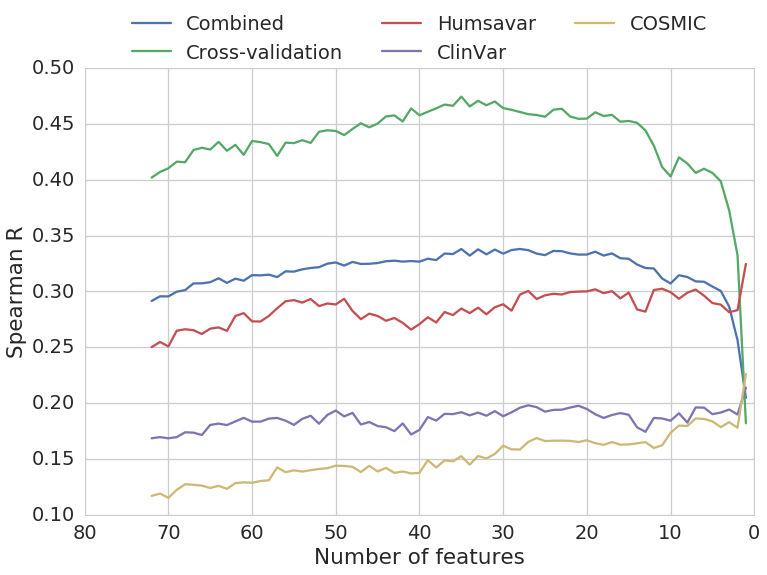

In [75]:
# Train curve for feature elimination
print('Feature elimination on the train dataset')

fg, ax = plt.subplots(figsize=(12, 8))

for test_column, test_label in get_test_columns(suffix_test=''):
    plt.plot(
        feature_elimination_wtest_df['n_features'], 
        feature_elimination_wtest_df[test_column], label=test_label)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()

Feature elimination on the validation dataset


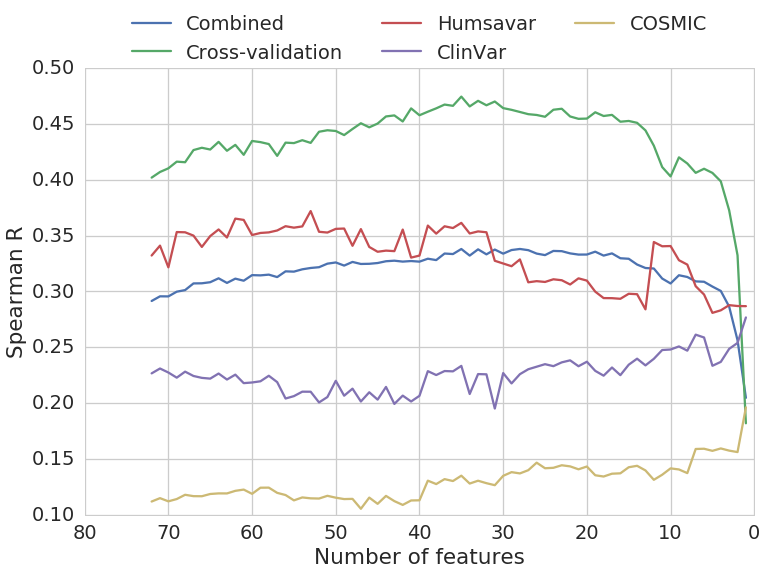

In [76]:
# Validation curve for feature elimination
print("Feature elimination on the validation dataset")

fg, ax = plt.subplots(figsize=(12, 8))

for test_column, test_label in get_test_columns(suffix_test='_test'):
    plt.plot(
        feature_elimination_wtest_df['n_features'], 
        feature_elimination_wtest_df[test_column], label=test_label)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()

n_features_best 28.0


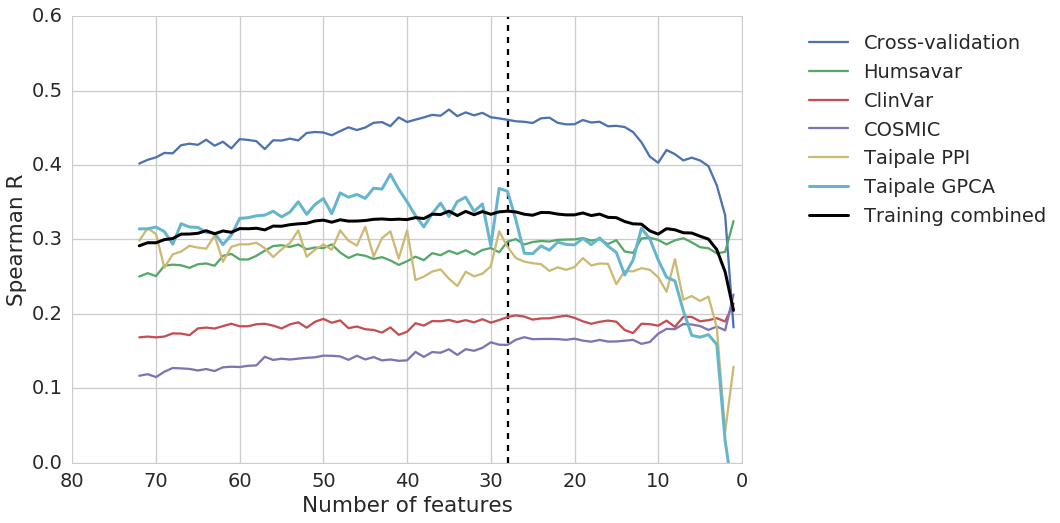

In [77]:
# Train + validation curve for feature elimination
DO_TEST = False
test_suffixes = ['', '_test'] if DO_TEST else ['']

df = feature_elimination_wtest_df
fg, ax = plt.subplots(figsize=(12, 8))

plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['spearmanr'], 
         label='Cross-validation', 
         color=sns.palettes.color_palette()[0], 
         linestyle='-')

for test_suffix in test_suffixes:
    plt.plot(feature_elimination_wtest_df['n_features'], 
             feature_elimination_wtest_df['spearmanr_humsavar{}_del_class_exp_vs_ddg'.format(test_suffix)], 
             label='Humsavar' + test_suffix.replace('_', ' ').upper(), 
             color=sns.palettes.color_palette()[1], 
             linestyle='--' if test_suffix else '-')

for test_suffix in test_suffixes:
    plt.plot(df['n_features'], 
             feature_elimination_wtest_df['spearmanr_clinvar{}_del_class_exp_vs_ddg'.format(test_suffix)], 
             label='ClinVar' + test_suffix.replace('_', ' ').upper(),
             color=sns.palettes.color_palette()[2], 
             linestyle='--' if test_suffix else '-')

for test_suffix in test_suffixes:
    plt.plot(feature_elimination_wtest_df['n_features'], 
             feature_elimination_wtest_df['spearmanr_cosmic{}_del_class_exp_vs_ddg'.format(test_suffix)], 
             label='COSMIC' + test_suffix.replace('_', ' ').upper(),
             color=sns.palettes.color_palette()[3],
             linestyle='--' if test_suffix else '-')

    
if CORE_OR_INTERFACE in [0, 'core']:
    plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['spearmanr_taipale_ddg_exp_vs_ddg'], 
         label='Taipale', 
         color=sns.palettes.color_palette()[4],
         linestyle='-')

    

if CORE_OR_INTERFACE in [1, 'interface']:
    plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['spearmanr_taipale_ppi_ddg_exp_vs_ddg'], 
         label='Taipale PPI', 
         color=sns.palettes.color_palette()[4],
         linestyle='-')

    plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['spearmanr_taipale_gpca_ddg_exp_vs_ddg'], 
         label='Taipale GPCA', 
         color=sns.palettes.color_palette()[5], 
         linestyle='-',
         linewidth=3)


plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['correlation_avg'], 
         label='Training combined', 
         color='k', 
         linestyle='-',
         linewidth=3)


# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=5)
plt.ylim(0, 0.6)
plt.legend(loc='upper right', bbox_to_anchor=(1.48, 1), ncol=1)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()


n_features_best = df[df['correlation_avg'] == df['correlation_avg'].max()]['n_features'].values[0]
# n_features_best = 6
print('n_features_best', n_features_best)
plt.vlines(n_features_best, 0, 0.6, linestyle='--')

plt.savefig(
    op.join(NOTEBOOK_NAME, 'feature_elimination{}.png'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'feature_elimination{}.pdf'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight')

In [78]:
feature_elimination_wtest_df.sort_values('correlation_avg').tail(5)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg,pearsonr_clinvar_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg,pearsonr_clinvar_test_del_class_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg,pearsonr_clinvar_test_del_score_exp_vs_ddg_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_score_exp_vs_ddg_gt80,pearsonr_clinvar_test_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_del_class_exp_vs_ddg,pearsonr_cosmic_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_del_score_exp_vs_ddg,pearsonr_cosmic_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg,pearsonr_cosmic_test_del_class_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg,pearsonr_cosmic_test_del_score_exp_vs_ddg_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_lt40,pearsonr_humsavar_del_class_exp_vs_ddg,pearsonr_humsavar_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg,pearsonr_humsavar_test_del_class_exp_vs_ddg_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_lt40,pearsonr_taipale_ddg_exp_vs_ddg,pearsonr_taipale_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ddg_exp_vs_ddg_lt40,pearsonr_taipale_gpca_ddg_exp_vs_ddg,pearsonr_taipale_gpca_ddg_exp_vs_ddg_40to80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_gt80,pearsonr_taipale_gpca_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ppi_ddg_exp_vs_ddg,pearsonr_taipale_ppi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ppi_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg,r2_clinvar_del_class_exp_vs_ddg_40to80,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del

In [79]:
n_features_best

28.0

In [80]:
features_best = (
    feature_elimination_wtest_df[
        feature_elimination_wtest_df['n_features'] == n_features_best
    ]['features'].values[0].split(':')
)
sorted(features_best)

['alignment_score',
 'backbone_clash_change',
 'backbone_clash_wt',
 'backbone_hbond_change',
 'cis_bond_wt',
 'electrostatic_kon_wt',
 'energy_ionisation_wt',
 'entropy_complex_change',
 'entropy_sidechain_change',
 'intraclashes_energy_2_change',
 'partial_covalent_bonds_wt',
 'pcv_hbond_self_change',
 'pcv_hbond_wt',
 'pcv_salt_equal_self_change',
 'pcv_salt_equal_wt',
 'pcv_salt_opposite_change',
 'pcv_salt_opposite_self_change',
 'pcv_salt_opposite_self_wt',
 'pcv_vdw_self_change',
 'pcv_vdw_self_wt',
 'pcv_vdw_wt',
 'provean_score',
 'sloop_entropy_change',
 'solvation_hydrophobic_change',
 'solvation_polar_change',
 'solvation_polar_wt',
 'torsional_clash_change',
 'water_bridge_change']

In [81]:
clf_options_best = (
    feature_elimination_wtest_df[
        feature_elimination_wtest_df['n_features'] == n_features_best
    ]['clf_opts'].values[0]
)
clf_options_best

{'alpha': 0.9,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.7655172413793103,
 'min_samples_leaf': 13,
 'n_estimators': 2000}

# Train final predictor

In [82]:
import sklearn
clf = sklearn.ensemble.GradientBoostingRegressor(**clf_options_best)

In [83]:
clf.fit(
    TRAINING_SETS_NONULL[TRAINING_DATASET_NAME][features_best],
    TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['ddg_exp'])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='huber', max_depth=4, max_features=0.7655172413793103,
             max_leaf_nodes=None, min_samples_leaf=13, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [84]:
with open(op.join(NOTEBOOK_NAME, 'clf_features{}.json'.format(COI_SUFFIX)), 'w') as ofh:
    json.dump(features_best, ofh)

In [85]:
with open(op.join(NOTEBOOK_NAME, 'clf_options{}.json'.format(COI_SUFFIX)), 'w') as ofh:
    json.dump(clf_options_best, ofh)

In [86]:
with open(op.join(NOTEBOOK_NAME, 'clf{}.pkl'.format(COI_SUFFIX)), 'wb') as ofh:
    pickle.dump(clf, ofh, pickle.HIGHEST_PROTOCOL)

# Done

In [87]:
print(datetime.datetime.now())

2016-09-23 17:38:31.903182


# Compare with FoldX

In [88]:
for _df in TRAINING_SETS_NONULL.values():
    if not _df.empty:
        _df['ddg_pred'] = clf.predict(_df[features_best])

In [89]:
training_pdb_mutations = set(
    TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['pdb_id'] + '.' + 
    TRAINING_SETS_NONULL[TRAINING_DATASET_NAME]['pdb_mutation']
)


def get_title(dataset):
    dataset_dict = {
        'ab_bind': 'AB-Bind',
        'benedix_et_al': 'Benedix',
        'hiv_escape_mutations': 'HIV',
        'taipale_ppi': 'Taipale',
        'taipale_ppi': 'Taipale PPI',
        'taipale_gpca': 'Taipale GPCA',
        'cagi4_sumo_ligase': 'SUMO',
    }
    dataset = dataset.replace('_train', '').replace('_test', '')
    try:
        dataset = dataset_dict[dataset]
    except KeyError:
        dataset = dataset.capitalize()
    return dataset

In [90]:
len(training_pdb_mutations)

2617

humsavar_train
clinvar_train
cosmic_train
taipale_train
taipale_ppi_train
taipale_gpca_train


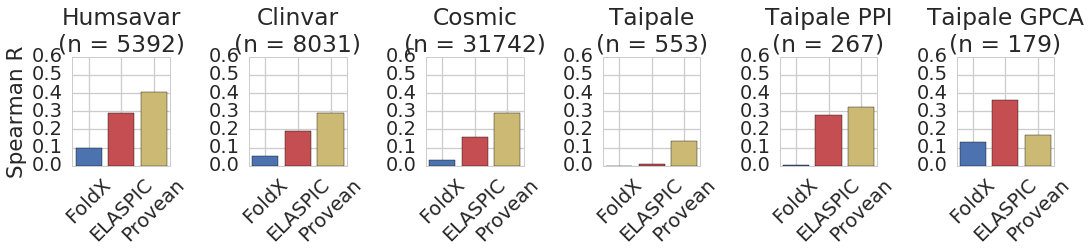

In [91]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
if CORE_OR_INTERFACE in [0, 'core']:
    test_datasets = [
        'humsavar_train', 'clinvar_train', 'cosmic_train',
        'taipale_train',
    ]
    
if CORE_OR_INTERFACE in [1, 'interface']:
    test_datasets = [
        'humsavar_train', 'clinvar_train', 'cosmic_train',
        'taipale_train', 'taipale_ppi_train', 'taipale_gpca_train',
    ]

fg, axes = plt.subplots(1, len(test_datasets), figsize=(2.5 * len(test_datasets) + 0.5, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate(test_datasets):
    print(test_dataset)
    df = TRAINING_SETS_NONULL[test_dataset].copy()
    ax = axes[i]
    if test_dataset != 'skempi':
        _before = df.shape[0]
        df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
        df = df[~df['_unique_id'].isin(training_pdb_mutations)]
        if df.shape[0] != _before:
            print("Lost {} rows due to overlap with Skempi".format(_before - df.shape[0]))

    if test_dataset in ['skempi', 'taipale_train', 'taipale_ppi_train', 'taipale_gpca_train']:
        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', 'ddg_exp'], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))

        foldx_r = abs(sp.stats.spearmanr(
            vals['dg_change'], 
            vals['ddg_exp'])[0])
        if test_dataset == 'skempi':
            elaspic_r = 0.456105
        else:
            elaspic_r = abs(sp.stats.spearmanr(
                vals['ddg_pred'], 
                vals['ddg_exp'])[0])
        provean_r = abs(sp.stats.spearmanr(
            vals['provean_score'], 
            vals['ddg_exp'])[0])
        title = '{}\n(n = {})'.format(get_title(test_dataset), vals.shape[0])
    else:
        vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', 'del_class_exp'], how='any')
        if vals.shape[0] != df.shape[0]:
            print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
            print(df[['dg_change', 'ddg_pred', 'provean_score', 'del_class_exp']].isnull().sum())

        foldx_r = sp.stats.spearmanr(
            vals['dg_change'],  # NO ABS!!!
            vals['del_class_exp'])[0]
        elaspic_r = sp.stats.spearmanr(
            vals['ddg_pred'],  # NO ABS!!!
            vals['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(
            vals['provean_score'], 
            vals['del_class_exp'])[0] * -1
        title = '{}\n(n = {})'.format(get_title(test_dataset), vals.shape[0])
    ax.bar(
        [1, 2, 3], 
        [foldx_r, elaspic_r, provean_r],
        tick_label=['FoldX', 'ELASPIC', 'Provean'],
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[2],
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.6)
    ax.set_title(title)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()


for j in range(i + 1, len(test_datasets)):
    ax = axes[j]
    ax.axis('off')
# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.pdf'), bbox_inches='tight')

In [92]:
TRAINING_SETS_NONULL['benedix_et_al'].head()

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt,unique_id,lco_id,lco_group,ddg_pred
661,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,0.06095,2.22503,0.034380,-1.100150,NaN,NaN,NaN,NaN,Y,0.0,0.0,NaN,NaN,NaN,NaN,0.000000,2.431894,NaN,NaN,NaN,NaN,benedix_et_al,NaN,0.103925,-0.21,NaN,NaN,0.86307,4.18029,0.0,1.776360e-15,NaN,NaN,0.000000,0.081257,0.000000,0.298940,0.000000e+00,0.000000e+00,0.0,2.384,0.00000,2.50742,-0.01983,1.18613,NaN,0.000000,-0.015211,NaN,NaN,NaN,NaN,NaN,2.0,"[0, 2]",NaN,NaN,168.485,67.335,235.820,NaN,-0.0063,43.8147,0.0000,81.7971,NaT,-2.0,100.0,0.0,0.0,NaN,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,N93A,,N307A,-0.404127,343.0,NaN,0.0,0.0,NaN,NaN,NaN,-1.0,-5.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,21.0,9.0,Y,3hfm,Y_N93A,NaN,PF00062,NaN,NaN,-1.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4.0,NaN,1.08089,-2.79955,0.0,0.0,0.09790,-5.06330,-0.29112,8.89029,1.137807,49.746769,"222.206,-171.387,-100.349,-375.476,-8.89289,51...","221.244,-172.095,-102.061,-376.182,-8.89289,51...",NaN,NaN,0.000595,0.179833,NaN,NaN,NaN,NaN,P00698,NaN,NaN,N111A,NaN,NaN,0.18049,-0.220230,2.69718,-5.06655,0.0,0.0,P00698.N1

humsavar_test
clinvar_test
cosmic_test
cagi4_sumo_ligase
ab_bind
Lost 79 rows due to overlap with Skempi
hiv_escape_mutations
benedix_et_al
Lost 76 rows due to overlap with Skempi


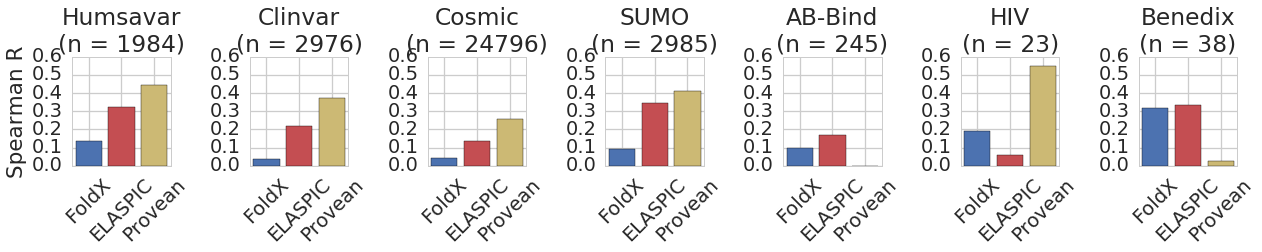

In [93]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
if CORE_OR_INTERFACE in [0, 'core']:
    test_datasets = [
        'humsavar_test', 'clinvar_test', 'cosmic_test', 
        'cagi4_sumo_ligase', 'ab_bind',
        'hiv_escape_mutations', 
        # 'benedix_et_al', 
    ]
    
if CORE_OR_INTERFACE in [1, 'interface']:
    test_datasets = [
        'humsavar_test', 'clinvar_test', 'cosmic_test', 
        'cagi4_sumo_ligase', 'ab_bind',
        'hiv_escape_mutations', 
        'benedix_et_al', 
    ]

fg, axes = plt.subplots(1, len(test_datasets), figsize=(2.5 * len(test_datasets) + 0.5, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate(test_datasets):
    print(test_dataset)
    df = TRAINING_SETS_NONULL[test_dataset].copy()
    ax = axes[i]
    if test_dataset != 'skempi':
        _before = df.shape[0]
        df['_unique_id'] = (df['pdb_id'] + '.' + df['pdb_mutation'])
        df = df[~df['_unique_id'].isin(training_pdb_mutations)]
        if df.shape[0] != _before:
            print("Lost {} rows due to overlap with Skempi".format(_before - df.shape[0]))

    if test_dataset in ['ab_bind', 'benedix_et_al', 'hiv_escape_mutations']:
        ddg_key = 'ddg_exp'
    elif test_dataset in ['cagi4_sumo_ligase']:
        ddg_key = 'del_score_exp'
    else:
        ddg_key = 'del_class_exp'
        
    vals = df.dropna(subset=['dg_change', 'ddg_pred', 'provean_score', ddg_key], how='any')
    if vals.shape[0] != df.shape[0]:
        print("Lost {} rows with nulls".format(df.shape[0] - vals.shape[0]))
        print(df[['dg_change', 'ddg_pred', 'provean_score', ddg_key]].isnull().sum())
        if vals.empty:
            raise Exception("No data!")

    foldx_r = abs(sp.stats.spearmanr(
        vals['dg_change'], 
        vals[ddg_key])[0])
    elaspic_r = abs(sp.stats.spearmanr(
        vals['ddg_pred'], 
        vals[ddg_key])[0])
    provean_r = abs(sp.stats.spearmanr(
        vals['provean_score'], 
        vals[ddg_key])[0])
    title = '{}\n(n = {})'.format(get_title(test_dataset), vals.shape[0])

    ax.bar(
        [1, 2, 3], 
        [foldx_r, elaspic_r, provean_r],
        tick_label=['FoldX', 'ELASPIC', 'Provean'],
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[2],
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.6)
    ax.set_title(title)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.pdf'), bbox_inches='tight')